# Object detetction: Faster-RCNN algorithm

## Done by: Amrou CHOUCHENE & Wassim BOUATAY

In this notebook, we will apply the FasterRCNN algorithm to detect objects in images. We will use COCO val2014 data set.


In [1]:
!pip install mapcalc

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import cv2
from __future__ import division
import scipy.optimize
from mapcalc import calculate_map
import time
import pandas as pd
import warnings
warnings.simplefilter(action='ignore')

# Loading COCO dataset

In [3]:
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# !unzip '/content/drive/My Drive/val2014' -d '/content/drive/My Drive/'

In [5]:
coco = dset.CocoDetection(root = '/content/drive/My Drive/val2014',
                        annFile = '/content/drive/My Drive/instances_val2014.json',
                        transform=torchvision.transforms.ToTensor())

loading annotations into memory...
Done (t=4.58s)
creating index...
index created!


# COCO labels and frequency

### Labels

In [6]:
CATEGORY_NAMES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

labels = { i:CATEGORY_NAMES[i-1] for i in range(1, 1+len(CATEGORY_NAMES))}
labels

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 12: 'N/A',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 26: 'N/A',
 27: 'backpack',
 28: 'umbrella',
 29: 'N/A',
 30: 'N/A',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 45: 'N/A',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 66: 'N/A'

### Frequency 


This part was used to see the distribution of the data over the different classes and to determine the top 10 most frequent classes that we will focus on. We omit this part because it takes around a long time. The results of this part can be found in our report.

In [7]:
"""
objects = []
val_size = len(coco)
for i in range(len(coco)):
  try:
    if i%5000==0:
      print(i)
    _, target = coco[i]   
    for obj in target:
      objects.append(obj['category_id'])
  except:
    val_size -= 1
objects = np.array(objects)
print('\n', val_size)
"""

"\nobjects = []\nval_size = len(coco)\nfor i in range(len(coco)):\n  try:\n    if i%5000==0:\n      print(i)\n    _, target = coco[i]   \n    for obj in target:\n      objects.append(obj['category_id'])\n  except:\n    val_size -= 1\nobjects = np.array(objects)\nprint('\n', val_size)\n"

In [8]:
"""
(unique, counts) = np.unique(objects, return_counts=True)
L = [[labels[unique[i]], counts[i]] for i in range(len(unique))]
L = sorted(L, key = lambda x: x[1], reverse=True)
L_freq = [ i[1] for i in L ]
L_labels =  [ i[0] for i in L ]
"""

'\n(unique, counts) = np.unique(objects, return_counts=True)\nL = [[labels[unique[i]], counts[i]] for i in range(len(unique))]\nL = sorted(L, key = lambda x: x[1], reverse=True)\nL_freq = [ i[1] for i in L ]\nL_labels =  [ i[0] for i in L ]\n'

In [9]:
"""
top_ten = L_labels[0:10]
plt.figure(figsize=(10,10))
plt.bar(L_labels[0:10], L_freq[0:10])
plt.title('Top 10 most frequent objects')
"""

"\ntop_ten = L_labels[0:10]\nplt.figure(figsize=(10,10))\nplt.bar(L_labels[0:10], L_freq[0:10])\nplt.title('Top 10 most frequent objects')\n"

## plot boxes

In [12]:
def plot_boxes(img, target, prediction =[]):
  """
  output:
  This function allows to plot the ground truth bounding boxes in green and the 
  predicted bounding boxes in red along the class of the object. We also add the 
  probability of the object in the case of predicted boxes.
  ---
  input:
  - img: from the coco dataloader
  - target: from the coco dataloader too, contains information about the label and 
  the bounding box in the format [top_left xmin, top_left ymin, width, height]
  - prediction: the output of the fasterrcnn model contins information aoubt the 
  the label, the probability of the object and the bounding box in the format 
  [ top_left xmin, top_left ymin, lower_right xmax, lower_right ymax) ]
  """
  img = img.numpy()
  img = np.transpose(img, (1, 2, 0))

  for obj in target:
    box = obj['bbox']
    left = int(box[0])
    top = int(box[1])
    right = int(box[0]+box[2])
    bottom = int(box[1]+box[3])
    label = labels[obj['category_id']]
    imgHeight, imgWidth, _ = img.shape
    thick = int((imgHeight + imgWidth) // 500)
    color = (0,255,0)
    img = cv2.rectangle(img, (left, top), (right, bottom), color, thick)
    img = cv2.putText(img, label, (left, top + 12), 0, 1e-3 * imgHeight, color, thick//2)
    try:
      img = cv2.UMat.get(img)
    except:
      continue

  for obj in prediction:
    box = obj['bbox']
    left = int(box[0])
    top = int(box[1])
    right = int(box[2])
    bottom = int(box[3])
    label = labels[obj['category_id']]
    score = obj['scores']
    imgHeight, imgWidth, _ = img.shape
    thick = int((imgHeight + imgWidth) // 500) 
    color = (255,0,0)
    img = cv2.rectangle(img, (left, top), (right, bottom), color, thick)
    img = cv2.putText(img, label+"-{:.2f}".format(score), (left, top + 12), 0, 1e-3 * imgHeight, color, thick//3)
    try:
      img = cv2.UMat.get(img)
    except:
      continue
  plt.imshow(img)

### Example of the plot on an image of the COCO dataloader 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[13.0, 22.75, 535.98, 609.67] 4
[1.66, 3.32, 268.6, 271.91] 4


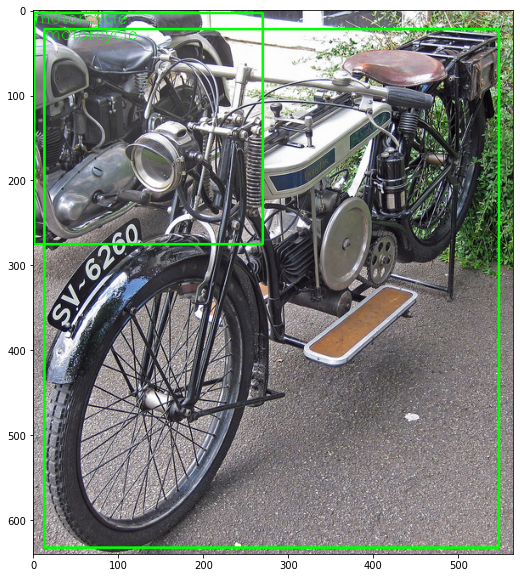

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.84, 114.71, 53.54, 257.7] 1
[0.0, 61.35, 68.92, 312.65] 1
[82.0, 116.38, 185.74, 252.68] 25
[316.72, 131.83, 128.04, 164.25] 25


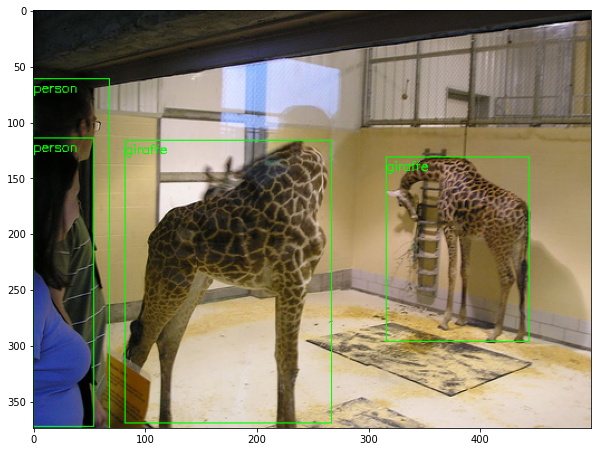

In [13]:
for i in range(5):
  try:
    img, target = coco[i]

    for obj in target:
      print(obj['bbox'], obj['category_id'])

    plt.figure(figsize=(10,10))
    plot_boxes(img, target)
    plt.show()
  except:
    continue

## Box selection


In [14]:
def bbox_iou(boxA, boxB):
  """
  Calculating the IoU between 2 boxes in the format 
  [ top_left xmin, top_left ymin, lower_right xmax, lower_right ymax) ]
  """
  # Determine the coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  interW = xB - xA + 1
  interH = yB - yA + 1

  # Reject non-overlapping boxes
  if interW <=0 or interH <=0 :
    return -1.0

  interArea = interW * interH
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  iou = interArea / float(boxAArea + boxBArea - interArea)
  return iou

In [15]:
def match_bboxes(bbox_gt, bbox_pred, IOU_THRESH=0.5):
    """
    determine the best possible match of COCO (gt) and predicted bounding-boxes
    ----------
    Input
    bbox_gt [x1, y1, w ,h], bbox_pred [x1,y1,x2,y2]. 
    ---------
    Return
    (idxs_true, idxs_pred, ious, labels, avg_iou)
        idxs_true, idxs_pred : indices into gt and pred for matches
        ious : corresponding IoU value of each match
        labels: vector of 0/1 values for the list of detections
        avg_iou: average IoU of all the boxes in the image
    """
    n_true = bbox_gt.shape[0]
    n_pred = bbox_pred.shape[0]
    MAX_DIST = 1.0
    MIN_IOU = 0.0

    # NUM_GT x NUM_PRED
    iou_matrix = np.zeros((n_true, n_pred))
    for i in range(n_true):
        for j in range(n_pred):
            iou_matrix[i, j] = bbox_iou(bbox_gt[i,:], bbox_pred[j,:])

    if n_pred > n_true:
      # there are more predictions than ground-truth - add dummy rows
      diff = n_pred - n_true
      iou_matrix = np.concatenate( (iou_matrix, 
                                    np.full((diff, n_pred), MIN_IOU)), 
                                  axis=0)

    if n_true > n_pred:
      # more ground-truth than predictions - add dummy columns
      diff = n_true - n_pred
      iou_matrix = np.concatenate( (iou_matrix, 
                                    np.full((n_true, diff), MIN_IOU)), 
                                  axis=1)

    # call the Hungarian matching
    idxs_true, idxs_pred = scipy.optimize.linear_sum_assignment(1 - iou_matrix)

    if (not idxs_true.size) or (not idxs_pred.size):
        ious = np.array([])
    else:
        ious = iou_matrix[idxs_true, idxs_pred]

    # remove dummy assignments
    sel_pred = idxs_pred<n_pred
    idx_pred_actual = idxs_pred[sel_pred] 
    idx_gt_actual = idxs_true[sel_pred]
    ious_actual = iou_matrix[idx_gt_actual, idx_pred_actual]
    sel_valid = (ious_actual > IOU_THRESH) 
    label = sel_valid.astype(int)
    return idx_gt_actual[sel_valid], idx_pred_actual[sel_valid], ious_actual[sel_valid], label

# Evaluation

In [16]:
def gt_boxes_format(box):
  """
  transform the format of a box to the format [x1,y1,x2,y2]
  """
  return [box[0], box[1], box[0]+box[2], box[1]+box[3]]


def mAP_format(boxes_labels, dict_type):
  """
  change predictions/ground truth to the required format of the function_map
  dict_type = 0 -> ground_truth_dict with {boxes:, labels:}
  dict_type = 1 -> predict_dict with {boxes:, labels:, scores:}
  """
  if dict_type==0: 
    ## ground truth
    res = {'boxes':[], 'labels':[]}
  else: 
    ## prediction
    res = {'boxes':[], 'labels':[], 'scores':[]}

  for i in boxes_labels:
    if dict_type==0: 
      ## ground truth
      res['boxes'].append(gt_boxes_format(i['bbox']))
    else:  
      ## prediction
      res['boxes'].append(i['bbox'])

    res['labels'].append(i['category_id'])
    
    if dict_type==1:
      res['scores'].append(i['scores'])

  return res

#### Import a pretrained Faster RCNN model from torchvision.models

In [17]:
FRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) ##returns top_left(xmin, ymin), lower_right(xmax, ymax)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FRCNN.eval().to(device)
print(device)

cuda


In [18]:
def prediction(image, model = FRCNN, threshold=0.5):
    """
    - returns the bounding boxes (with corresponding scores and labels)
    satisfying a score > threshold
    - the list of output have the same format as the one of COCO dataloader
     (except the format of the boxes): ie We have a list of objects: each object 
     is a dictionnaire.
    """
    # transform the image to tensor
    image = image.to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image)[0] # get the predictions on the image

    res = []
    for i in range(len(outputs['labels'])):
      if outputs['scores'][i].item()>=threshold:
        res.append({'bbox':[int(outputs['boxes'][i][0].item()), int(outputs['boxes'][i][1].item()), int(outputs['boxes'][i][2].item()), \
                            int(outputs['boxes'][i][3].item())], 'category_id':outputs['labels'][i].item(), 'scores':outputs['scores'][i].item()})
    return res

#### Prepare the table of metrics

We will perform our evaluation of FasterRCNN based the following criterion:

1/ Time complexity

2/ IoU between predicted and ground truth boxes

3/ Precision

4/ Recall

5/ mAP (area under curve)

In [19]:
columns = {'Metrics':['mAP@.75', 'IoU', 'Recall', 'Precision'], 'All Classes':[0]*4,\
           'person':[0]*4, 'car':[0]*4, 'chair':[0]*4, 'book':[0]*4, \
           'bottle':[0]*4, 'cup':[0]*4, 'dining table':[0]*4, 'bowl':[0]*4, \
           'traffic light':[0]*4, 'handbag':[0]*4, 'Rare Classes':[0]*4}
df = pd.DataFrame(columns, dtype='float')
df.set_index('Metrics')
df

,Metrics,All Classes,person,car,chair,book,bottle,cup,dining table,bowl,traffic light,handbag,Rare Classes
0,mAP@.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,IoU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Recall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Precision,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Testing step

In [20]:
nbr_samples = 0 ## keep track of the number of images
total_time = 0

## images_per_class: keep track of the number of images containing an object of the specified class
images_per_class = {'person':0, 'car':0, 'chair':0, 'book':0, 'bottle':0, \
                    'cup':0, 'dining table':0, 'bowl':0, 'traffic light':0,\
                    'handbag':0, 'other':0} 
nbr_iou_per_class = {'all':0, 'person':0, 'car':0, 'chair':0, 'book':0, 'bottle':0, \
                    'cup':0, 'dining table':0, 'bowl':0, 'traffic light':0,\
                    'handbag':0, 'other':0}                   

## Top 10 most frequent classes
top_ten = ['person', 'car', 'chair', 'book', 'bottle', 'cup', 'dining table', 'bowl', 'traffic light', 'handbag']

## Looping over the images of COCO dataset
for idx in range(1500):
  if (idx+1)%250==0:
    print("image nbr", idx+1)

  try:
    ## Some images are damaged and can't be opened
    img, target = coco[idx]
  except:
    continue
  
  start_time = time.time()
  pred = prediction(img, threshold=0.7)
  total_time += time.time() - start_time ## are interested only on the execution time of FasterRCNN

  ########################################
  ###### Update ALL Classes Column #######
  ########################################
  pred_boxes = np.array([ i['bbox'] for i in pred ]) ## matrix of predicted boxes' coordinates
  gt_boxes = np.array([ gt_boxes_format(i['bbox']) for i in target ]) ## matrix of the ground truth boxes ' coordinates

  gt_selected_idx, selected_idx,iou,_ = match_bboxes(gt_boxes,pred_boxes, IOU_THRESH=0.6)
  final_pred = [pred[i] for i in selected_idx]         ## selected predicted boxes that matches the target
  final_target = [target[i] for i in gt_selected_idx]  ## selected target boxes

  if len(target)!=0:
    ## Sometimes, images doesn't have any ground truth boxes so we skip them
    
    recall = len(final_pred)/len(target)  ## nbr of correct predicted boxes / nbr of true boxes
    if len(pred)==0:
      ## we didnt predict any box, so metrics should be 0 
      precision = 0
    else:
      precision = len(final_pred)/len(pred) ## nbr of true predicted boxes / nbr of predicted boxes

    for i in range(len(pred)):
      if i not in selected_idx:
        final_pred.append(pred[i])
        final_target.append({'bbox':[0, 3, 0, 3], 'category_id':1}) ## dummy ground-truth

    for i in range(len(target)):
      if i not in gt_selected_idx:
        final_target.append(target[i])
        final_pred.append({'bbox':[0, 3, 0, 3], 'category_id':1, 'scores':0.8}) ## dummy prediction

    if len(final_target)==0 or len(final_pred)==0:
      ## this is used as an estimation of mAP when it doesnt exist
      mAP = 0
    else:
      mAP = calculate_map( mAP_format(final_target,0), mAP_format(final_pred,1), 0.75)
        
    ## update metrics table
    df['All Classes'][0] += mAP
    if iou.shape[0]!=0:
      df['All Classes'][1] += np.sum(iou)
      nbr_iou_per_class['all'] += iou.shape[0]
    df['All Classes'][2] += recall
    df['All Classes'][3] += precision

    nbr_samples += 1

  ###########################################
  ###### Update Top TEN LABELS Column #######
  ###########################################
  for label in top_ten:
    ## keep only bounding boxes for the object of a certain class
    pred_boxes = np.array([ i['bbox'] for i in pred if labels[i['category_id']]==label])  ## matrix of predicted boxes' coordinates of a certain class
    pred_boxes_inx = [ i for i in range(len(pred)) if labels[pred[i]['category_id']]==label ]   ##indices in pred of candidate boxes

    gt_boxes = np.array([ gt_boxes_format(i['bbox']) for i in target if labels[i['category_id']]==label])  ## matrix of target boxes' coordinates of a certain class
    gt_boxes_inx = [ i for i in range(len(target)) if labels[target[i]['category_id']]==label ]  ##indices in target of candidate boxes

    if len(gt_boxes)!=0:
      ## There is exist an object of the specified class
      gt_selected_idx, selected_idx,iou,_ = match_bboxes(gt_boxes,pred_boxes, IOU_THRESH=0.6)
      selected_idx = [ pred_boxes_inx[i] for i in selected_idx]      ##indices in pred of selected boxes
      gt_selected_idx = [ gt_boxes_inx[i] for i in gt_selected_idx]  ##indices in target of selected boxes

      final_pred = [ pred[i] for i in range(len(pred)) if i in selected_idx ]   ## selected predicted boxes that matches the target
      final_target = [ target[i] for i in range(len(target)) if i in gt_selected_idx ]  ## selected target boxes

      recall = len(final_pred)/len(gt_boxes) ## nbr of correct predicted boxes / nbr of true boxes

      if len(pred_boxes)==0:
        ## we didnt predict any box, so metrics should be 0 
        precision = 0
      else:
        precision = len(final_pred)/len(pred_boxes) ## nbr of true predicted boxes / nbr of predicted boxes

      for i in range(len(pred)):
        if i not in selected_idx and pred[i]['category_id']==label:
          final_pred.append(pred[i])
          final_target.append({'bbox':[0, 3, 0, 3], 'category_id':1}) ## dummy ground-truth

      for i in range(len(target)):
        if i not in gt_selected_idx and target[i]['category_id']==label:
          final_target.append(target[i])
          final_pred.append({'bbox':[0, 3, 0, 3], 'category_id':1, 'scores':0.8}) ## dummy prediction

      if len(final_target)==0 or len(final_pred)==0:
        ## this is used as an estimation of mAP when it doesnt exist
        mAP = 0
      else:
        mAP = calculate_map( mAP_format(final_target,0), mAP_format(final_pred,1), 0.75)
      
      """
      if label=="book":
        print(idx)
        plt.figure(figsize=(8,8))
        plot_boxes(img, [], [ i for i in pred if labels[i['category_id']]==label])
        plt.show()
      """

      ## update metrics table        
      df[label][0] += mAP
      if iou.shape[0]!=0:
        df[label][1] += np.sum(iou)
        nbr_iou_per_class[label] += iou.shape[0]
      df[label][2] += recall
      df[label][3] += precision

      images_per_class[label] += 1

  #########################################
  ###### Update Rare Classes Column #######
  #########################################
    ## keep only bounding boxes for the rare classes 
    pred_boxes = np.array([ i['bbox'] for i in pred if labels[i['category_id']] not in top_ten ])  ## matrix of predicted boxes' coordinates of  rare classes
    pred_boxes_inx = [ i for i in range(len(pred)) if labels[pred[i]['category_id']] not in top_ten ]     ##indices in pred of candidate boxes

    gt_boxes = np.array([ gt_boxes_format(i['bbox']) for i in target if labels[i['category_id']] not in top_ten])  ## matrix of target boxes' coordinates of  rare classes
    gt_boxes_inx = [ i for i in range(len(target)) if labels[target[i]['category_id']] not in top_ten]   ##indices in target of candidate boxes

    if len(gt_boxes)!=0:
      ## There is exist an object of the rare classes
      gt_selected_idx, selected_idx,iou,_ = match_bboxes(gt_boxes,pred_boxes, IOU_THRESH=0.6)
      selected_idx = [ pred_boxes_inx[i] for i in selected_idx]      ##indices in pred of selected boxes
      gt_selected_idx = [ gt_boxes_inx[i] for i in gt_selected_idx]  ##indices in target of selected boxes

      final_pred = [ pred[i] for i in range(len(pred)) if i in selected_idx ]    ## selected predicted boxes that matches the target
      final_target = [ target[i] for i in range(len(target)) if i in gt_selected_idx ]   ## selected target boxes

      recall = len(final_pred)/len(gt_boxes) ## nbr of correct predicted boxes / nbr of true boxes
      if len(pred_boxes)==0:
        ## we didnt predict any box, so metrics should be 0 
        precision = 0
      else:
        precision = len(final_pred)/len(pred_boxes) ## nbr of true predicted boxes / nbr of predicted boxes

      for i in range(len(pred)):
        if i not in selected_idx and pred[i]['category_id'] not in top_ten:
          final_pred.append(pred[i])
          final_target.append({'bbox':[0, 3, 0, 3], 'category_id':1}) ## dummy ground-truth

      for i in range(len(target)):
        if i not in gt_selected_idx and target[i]['category_id'] not in top_ten:
          final_target.append(target[i])
          final_pred.append({'bbox':[0, 3, 0, 3], 'category_id':1, 'scores':0.8}) ## dummy prediction

      if len(final_target)==0 or len(final_pred)==0:
        ## this is used as an estimation of mAP when it doesnt exist
        mAP = 0
      else:
        mAP = calculate_map( mAP_format(final_target,0), mAP_format(final_pred,1), 0.75)
            
      ## update metrics table
      df['Rare Classes'][0] += mAP
      if iou.shape[0]!=0:
        df['Rare Classes'][1] += np.sum(iou)
        nbr_iou_per_class['other'] += iou.shape[0]
      df['Rare Classes'][2] += recall
      df['Rare Classes'][3] += precision

      images_per_class['other'] += 1

image nbr 250
image nbr 500
image nbr 750
image nbr 1000
image nbr 1250
image nbr 1500


In [21]:
print(images_per_class)

## Normalizing the output
for col in top_ten:
  if images_per_class[col]!=0:
    df[col][0] = df[col][0]/images_per_class[col]
    df[col][1] = df[col][1]/nbr_iou_per_class[col]
    df[col][2] = df[col][2]/images_per_class[col]
    df[col][3] = df[col][3]/images_per_class[col]

if images_per_class['other']!=0:
    df['Rare Classes'][0] = df['Rare Classes'][0]/images_per_class['other']
    df['Rare Classes'][1] = df['Rare Classes'][1]/nbr_iou_per_class['other']
    df['Rare Classes'][2] = df['Rare Classes'][2]/images_per_class['other']
    df['Rare Classes'][3] = df['Rare Classes'][3]/images_per_class['other']

if images_per_class['other']!=0:
    df['All Classes'][0] = df['All Classes'][0]/nbr_samples
    df['All Classes'][1] = df['All Classes'][1]/nbr_iou_per_class['all']
    df['All Classes'][2] = df['All Classes'][2]/nbr_samples
    df['All Classes'][3] = df['All Classes'][3]/nbr_samples

## Show results
df

{'person': 353, 'car': 70, 'chair': 61, 'book': 22, 'bottle': 40, 'cup': 43, 'dining table': 59, 'bowl': 34, 'traffic light': 19, 'handbag': 39, 'other': 6280}


,Metrics,All Classes,person,car,chair,book,bottle,cup,dining table,bowl,traffic light,handbag,Rare Classes
0,mAP@.75,0.590274,0.823922,0.693465,0.646403,0.515871,0.763065,0.808370,0.508475,0.730588,0.616165,0.178063,0.534678
1,IoU,0.841645,0.841498,0.840947,0.841589,0.801630,0.839078,0.846419,0.863787,0.869800,0.790354,0.762420,0.844780
2,Recall,0.771878,0.873700,0.685785,0.629899,0.520080,0.692232,0.736225,0.559322,0.744689,0.671505,0.237485,0.761075
3,Precision,0.780796,0.850507,0.695061,0.659680,0.616558,0.714762,0.794961,0.553672,0.801471,0.782895,0.329670,0.780032


In [22]:
print('Average execution time of Faster-RCNN per image {:.3}s'.format(total_time/nbr_samples))

Average execution time of Faster-RCNN per image 0.114s


In [23]:
print('Number of samples tested on', nbr_samples)

Number of samples tested on 642
